# Hyperparameter search over range data model

Due to the time the model takes to train (over 1 hour per epoch), using a 5 fold cross validation strategy (applied in notebook 8 for the CNN model) would take close to 50 hours per parameter configuration (assuming 10 epochs). Therefore to perform any meaningful search, it would take several weeks.

Furthermore, up until now the model has been only evaluated on subject B which has made the model bias towards this subject. To try and adjust for this the test set for the hyperparamter optimization will be taken from all subjects (except C). 20\% of the data from each subject will be used for validation. The data will be taken in consecutive chunks as there is little variation between two consecutive spectrograms.

The following parameters will remain fixed:
* Optimizer: 'adam'
* Batch size: 32
* Number of dense layers: 1
* Learning rate: 0.001
* Number of dense nodes: 512
* L2: 0.001
* Batch norm: False

Limited to 10 epochs as this takes around 15 hours == 11 evalauations in one week


## Notebook setup

In [1]:
# Plot graphs inline
%matplotlib inline

The following cell is needed for compatibility when using both CoLab and Local Jupyter notebook. It sets the appropriate file path for the data and also installs local packages such as models and data_loading.

In [2]:
import os
path = os.getcwd()
if path == '/content':
    from google.colab import drive
    drive.mount('/content/gdrive')
    BASE_PATH = '/content/gdrive/My Drive/Level-4-Project/'
    os.chdir('gdrive/My Drive/Level-4-Project/')
    
elif path == 'D:\\Google Drive\\Level-4-Project\\notebooks':
    BASE_PATH = "D:/Google Drive/Level-4-Project/"
    
elif path == "/export/home/2192793m":
    BASE_PATH = "/export/home/2192793m/Level-4-Project/"
    
    
DATA_PATH_MTI = BASE_PATH + 'data/processed/range_FFT/3/MTI_applied/' # not used
DATA_PATH_NO_MTI = BASE_PATH + 'data/processed/range_FFT/3/MTI_not_applied/'

RESULTS_PATH = BASE_PATH + 'results/range_data_model_hyperparameter_search/'
if not os.path.exists(RESULTS_PATH):
    os.makedirs(RESULTS_PATH)
    
MODEL_PATH = BASE_PATH + 'models/range_data_model_hyperparameter_search/'
if not os.path.exists(MODEL_PATH):
    os.makedirs(MODEL_PATH)

In [3]:
from keras import backend as K 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from keras.utils import Sequence, to_categorical
from keras.layers import Input, Conv1D, Multiply, Add, Activation, AveragePooling1D, Flatten, Dense
from keras.layers import BatchNormalization
from keras.regularizers import l2
from keras.models import Model
from keras.callbacks import EarlyStopping
import sys

Using TensorFlow backend.


In [4]:
# needed for CheckpointSaver
# https://github.com/scikit-optimize/scikit-optimize/issues/678
# ! pip install git+https://github.com/scikit-optimize/scikit-optimize/ 
    
from skopt import gp_minimize
from skopt.space import Integer
from skopt.utils import use_named_args
from skopt.callbacks import CheckpointSaver
from skopt import dump, load

## Data Setup

In [5]:
# Load in data dictionary.
# This does not load in any actual data,
# just the dictionary with the names of the files and their associated labels
with open(DATA_PATH_NO_MTI + "index.pkl", "rb") as file:
    data = pickle.load(file)

In [6]:
# Remove user C as this user is reserved for the test set
try:
    del data["C"]
except KeyError:
    print ("Key 'C' not found")

In [7]:
def convert_label_to_int(label):
    """
    Convert each label to an integer
    :param label: action label to convert
    :return: integer representation of the action
    """
    if label == "walking":
        return 0
    if label == "pushing":
        return 1
    if label == "sitting":
        return 2
    if label == "pulling":
        return 3
    if label == "circling":
        return 4
    if label == "clapping":
        return 5
    if label == "bending":
        return 6

So far the model has only been validated on subject B. This has likely introduced bias into the model. To combat this, the hyperparameter search will using 20% of the data from every subject for validation. To do this it will be made sure that the data is selected in consecutive chunks to negate the issue of consecutive range profiels being almost identical.

In [8]:
labels = {}
partition = {'train': [], 'validation': []}  # contains list of training and validation ID's

for user_letter, actions in data.items():
    for action, results in actions.items():
        for result in results:
            res = np.array(result)
            # Split into 5 folds then take 1 fold for 20%
            split_actions = np.array_split(res, 5)
            for fold in range(5):
                data = split_actions[fold]
                if fold == 0:
                    for row in data:
                        partition["validation"].append(row)
                        labels[row] = convert_label_to_int(action)

                else:
                    for row in data:
                        partition["train"].append(row)
                        labels[row] = convert_label_to_int(action)            


In [9]:
target_names = ["walking", "pushing", "sitting", "pulling", "circling", "clapping", "bending"]
nb_classes = len(target_names)

## DataGenerator

In [10]:
class DataGenerator(Sequence):
    """
    Based on code from https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly
    Keras data generator
    """
    def __init__(self, list_IDs, labels, batch_size=32, dim=(3000),
                 n_classes=7, shuffle=False, data_directory='data/',
                 bin_range=(0,60), take_average=False, every_second_cell=False):
        """
        Initialization
        :param list_IDs: IDs of files to train with
        :param labels: index to get associated label from file id
        :param batch_size: batch size
        :param dim: dimension of the input data
        :param n_classes: number of classes
        :param shuffle: shuffle data after each epoch toggle
        :param data_directory: path to the data
        :param bin_range: which range bins to use
        :param take_average: use the average of all cells toggle
        :param every_second_cell: use every second cell toggle
        """
        self.dim = dim
        self.batch_size = batch_size
        self.labels = labels
        self.list_IDs = list_IDs
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.data_directory = data_directory
        self.bin_range=bin_range
        self.take_average = take_average
        self.every_second_cell = every_second_cell
        self.indexes = None
        self.on_epoch_end()

    def __len__(self):
        """Denotes the number of batches per epoch"""
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        """Generate one batch of data"""

        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        """Updates indexes after each epoch"""
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        """Generates data containing batch_size samples"""
        # Initialization
        X = np.empty((self.batch_size, *self.dim))

        y = np.empty((self.batch_size), dtype=int)

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            if self.take_average:
                X[i,] = abs(np.average(np.load(self.data_directory + ID), axis=1)[:,np.newaxis])
                
            elif self.every_second_cell:
                X[i,] = abs(np.load(self.data_directory + ID))[:,::2]
                
            else:
                X[i,] = abs(np.load(self.data_directory + ID))[:,self.bin_range[0]:self.bin_range[1]]
                
            # Store class
            y[i] = self.labels[ID]

        return X, to_categorical(y, num_classes=self.n_classes)

### Visualize Results

In [11]:
def visualize_results(csvlog_path, metric, save=False, save_file_name=""):
    """
    plot graph of training and validation results
    :param csvlog_path: path where results file is located
    :param metric: metric to plot
    :param save: save the graph toggle
    :param save_file_name: name of file to save
    """
    df = pd.read_csv(RESULTS_PATH + csvlog_path)
    epoch = df['epoch'] +1
    train = df[metric]
    val = df['val_' + metric]
    plt.figure()
    plt.plot(epoch, train, label='train')
    plt.plot(epoch, val, label='val')
    plt.legend(loc='best')
    plt.xlabel('Epoch')
    plt.ylabel(metric)
    if save:
        plt.savefig(RESULTS_PATH + save_file_name, format='pdf')

## Model: Wavenet model adapted based on interpretation from Wavenet Paper

Keras implementation of wavenet model taken from https://github.com/basveeling/wavenet and https://github.com/mjpyeon/wavenet-classifier

This model has then been adapted to the classification task based on the intrustions from the paper "WAVENET: A GENERATIVE MODEL FOR RAW AUDIO" (https://arxiv.org/pdf/1609.03499.pdf)

Specifically:
"For this task we added a mean-pooling layer after the dilated convolutions that aggregated the activations to coarser frames spanning 10 milliseconds (160× downsampling).  The pooling layer was followed by a few non-causal convolutions."

In [12]:
class WaveNetClassifier:
    """
    Keras implementation of the WaveNet model based on implementations by
    https://github.com/basveeling/wavenet and https://github.com/mjpyeon/wavenet-classifier
    
    This model has then been adapted to the classification task based on the
    instructions from the paper "WAVENET: A GENERATIVE MODEL FOR RAW AUDIO" 
    (https://arxiv.org/pdf/1609.03499.pdf)
    """
    def __init__(self, input_shape, output_shape, kernel_size=2, dilation_depth=9, nb_stacks=1, nb_filters=40,
                 pool_size=80, kernel_size_2=100, use_skip_connections=True, causal=True, residual_l2=0.001,
                 conv_l2=0.001, fully_l2=0.001, use_batch_norm=True, num_dense_nodes=512):
        """
        Initialization
        :param input_shape: input shape of the data
        :param output_shape: number of classes
        :param kernel_size: kernel size for conv layers in stacks
        :param dilation_depth: number of dilated CNN layers per stack
        :param nb_stacks: number of stacks of dilated blocks
        :param nb_filters: number of filters for each conv layer
        :param pool_size: pooling size for average pooling layer
        :param kernel_size_2: kernel size for conv layers after stacks
        :param use_skip_connections: use skip connections toggle
        :param causal: use causal variant of model toggle
        :param residual_l2: value for l2 regularization in residual block
        :param conv_l2: l2 value for stack of standard conv layers
        :param fully_l2: l2 value for fully connected layer
        :param use_batch_norm: use batch norm toggle
        :param num_dense_nodes: number of dense nodes in fully connected layer
        """
        self.activation = 'softmax'
        self.pool_size = pool_size
        self.kernel_size_2 = kernel_size_2 # kernel size for later conV 1d (not dilated)
        self.nb_stacks = nb_stacks
        self.kernel_size = kernel_size # kernel size for dilated  layers
        self.dilation_depth = dilation_depth
        self.nb_filters = nb_filters
        self.residual_l2 = residual_l2 # l2 value for residual layers
        self.conv_l2 = conv_l2 # l2 value for stack of standard conv layers
        self.fully_l2 = fully_l2 # l2 value for fully connected layer
        self.use_skip_connections = use_skip_connections
        self.use_batch_norm = use_batch_norm
        self.num_dense_nodes = num_dense_nodes
        self.input_shape = input_shape
        self.output_shape = output_shape
        if causal:
            self.padding = 'causal'
        else:
            self.padding = 'same'

        self.model = self.build_model()

    def residual_block(self, x, i, stack_nb):
        """
        add a residual block
        :param x: current model
        :param i: dilation rate modifier
        :param stack_nb: stack number
        :return: model with residual block added, model for skip connection link
        """
        original_x = x
        tanh_out = Conv1D(self.nb_filters, self.kernel_size, dilation_rate=2 ** i, padding=self.padding,
                          name='dilated_conv_%d_tanh_s%d' % (2 ** i, stack_nb), activation='tanh',
                          kernel_regularizer=l2(self.residual_l2))(x)
        sigm_out = Conv1D(self.nb_filters, self.kernel_size, dilation_rate=2 ** i, padding=self.padding,
                          name='dilated_conv_%d_sigm_s%d' % (2 ** i, stack_nb), activation='sigmoid',
                          kernel_regularizer=l2(self.residual_l2))(x)
        x = Multiply(name='gated_activation_%d_s%d' % (i, stack_nb))([tanh_out, sigm_out])

        res_x = Conv1D(self.nb_filters, 1, padding='same', kernel_regularizer=l2(self.residual_l2))(x)
        skip_x = Conv1D(self.nb_filters, 1, padding='same', kernel_regularizer=l2(self.residual_l2))(x)
        res_x = Add()([original_x, res_x])
        return res_x, skip_x

    def build_model(self):
        """
        Build the model
        :return: keras model
        """
        input_layer = Input(shape=self.input_shape, name='input_part')
        out = input_layer
        skip_connections = []
        out = Conv1D(self.nb_filters, self.kernel_size,
                     dilation_rate=1,
                     padding=self.padding,
                     name='initial_causal_conv'
                     )(out)
        for stack_nb in range(self.nb_stacks):
            for i in range(0, self.dilation_depth + 1):
                out, skip_out = self.residual_block(out, i, stack_nb)
                skip_connections.append(skip_out)

        if self.use_skip_connections:
            out = Add()(skip_connections)
        out = Activation('relu')(out)
        # added a mean-pooling layer after the dilated convolutions that aggregated the activations to coarser frames
        # spanning 10 milliseconds (160× downsampling)
        # mean pooling layer adjust pool_size_1 to change downsampling
                
        out = AveragePooling1D(self.pool_size, padding='same', name='mean_pooling_layer_downsampling')(out)

        # few non-causal convolutions
        # In notebooks 11, 12 and 13 self.kernel_size_2 was incorrectly represented as pooling sizes.
        out = Conv1D(self.nb_filters, self.kernel_size_2, strides=2, padding='same', activation='relu',
                     kernel_regularizer=l2(self.conv_l2))(out)
        
        if self.use_batch_norm:
            out = BatchNormalization()(out)
        
        out = Conv1D(self.nb_filters, self.kernel_size_2, strides=2, padding='same', activation='relu',
                     kernel_regularizer=l2(self.conv_l2))(out)
        
        if self.use_batch_norm:
            out = BatchNormalization()(out)
        
        out = Conv1D(self.output_shape, self.kernel_size_2, strides=2, padding='same', activation='relu',
                     kernel_regularizer=l2(self.conv_l2))(out)
        
        if self.use_batch_norm:
            out = BatchNormalization()(out)
        
        out = Conv1D(self.output_shape, self.kernel_size_2, strides=2, padding='same', activation='relu',
                     kernel_regularizer=l2(self.conv_l2))(out)

        if self.use_batch_norm:
            out = BatchNormalization()(out)
            
        out = Flatten()(out)
        out = Dense(num_dense_nodes, activation='relu', kernel_regularizer=l2(self.fully_l2))(out)
        out = Dense(self.output_shape, activation='softmax')(out)

        return Model(input_layer, out)

    def get_model(self):
        return self.model

    def get_summary(self):
        self.model.summary()

    def get_receptive_field(self):
        """
        Compute the receptive field of the model
        :return: receptive field
        """
        k = self.kernel_size
        n = self.dilation_depth
        s = self.nb_stacks
        r_s = k + (2*(k-1)*((2**(n-1))-1))  # receptive field for one stack
        return (s*r_s) - (s-1)  # total receptive field for 's' number of stacks

## Hyperparameter Search

### Fixed Parameters

In [13]:
bin_range = (0, 63)
data_shape = (3000, 32)

activation = 'softmax'

epochs = 10  # number of epochs limited to 10 to allow more searches (15 hours per evaluation = 11 searches in one week)
batch_size = 16

num_dense_nodes = 512

residual_l2 = 0.001
conv_l2 = 0.001
fully_l2 = 0.001
use_batch_norm = False

# Parameters for data generators
data_gen_params = {'dim': data_shape,
                   'batch_size': batch_size,
                   'n_classes': nb_classes,
                   'data_directory': DATA_PATH_NO_MTI,
                   'bin_range': bin_range,
                   'every_second_cell': True}

### Parameters to Search

In [5]:
space = [
    Integer(32, 128, name="n_filters"),
    Integer(2, 5, name="kernel_size"),
    Integer(2, 9, name="dilation_depth"),
    Integer(1, 4, name="number_of_stacks"),
    Integer(4, 10, name="pool_size"),
    Integer(2, 8, name="kernel_size_2"),
    Integer(-1, 4, name='early_stopping_patience')
]

### Objective Function to Minimize

In [6]:
@use_named_args(space)
def objective(**params):
    """
    Objective function to be minimised during search. Returns validation loss
    :return: validation loss
    """
    wnc = WaveNetClassifier((data_shape), (nb_classes),
                            kernel_size=int(params["kernel_size"]),
                            dilation_depth=params["dilation_depth"],
                            nb_stacks=params["number_of_stacks"],
                            nb_filters=params["n_filters"],
                            pool_size=int(params["pool_size"]),
                            kernel_size_2=int(params["kernel_size_2"]),
                            num_dense_nodes=num_dense_nodes,
                            residual_l2=residual_l2,
                            conv_l2=conv_l2,
                            fully_l2=fully_l2,
                            use_batch_norm=use_batch_norm)

    model = wnc.get_model()

    training_generator = DataGenerator(partition["train"],
                                       labels,
                                       **data_gen_params, shuffle=True)
    
    validation_generator = DataGenerator(partition["validation"],
                                         labels,
                                         **data_gen_params, shuffle=False)

    model.compile('adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    patience = params["early_stopping_patience"]
    callback_list = []
    # -1 used to represent no early stopping
    if patience != -1:
        early_stopping = EarlyStopping(monitor='val_loss', patience=patience)
        callback_list.append(early_stopping)

    # Train model on dataset
    history = model.fit_generator(generator=training_generator,
                                  validation_data=validation_generator,
                                  epochs=epochs,
                                  callbacks=callback_list,
                                  verbose=1)
    val_loss = history.history["val_loss"][-1]
    K.clear_session()

    return val_loss  # minimize validation loss

### Callbacks

In [61]:
checkpoint = CheckpointSaver(RESULTS_PATH + "res_gp_checkpoint.pkl")
callbacks_list = [checkpoint]

### Load checkpoint

In [62]:
LOAD_CHECKPOINT = False

In [63]:
if LOAD_CHECKPOINT:
    res = load(RESULTS_PATH + "res_gp_checkpoint.pkl")
    x0 = res.x_iters
    y0 = res.func_vals
    random_starts = 0
    
else:
    x0 = None
    y0 = None
    random_starts = 5  # default is 10 

### Perform Search

In [64]:
res_gp = gp_minimize(objective, space, x0=x0, y0=y0,
                     n_calls=130, n_random_starts=random_starts,
                     random_state=0, callback=callbacks_list, verbose=True)

Iteration No: 1 started. Evaluating function at random point.
Epoch 1/10


ResourceExhaustedError: OOM when allocating tensor with shape[16,89,1,3000] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[Node: training/Adam/gradients/conv1d_35/convolution/Conv2D_grad/Conv2DBackpropFilter-0-TransposeNHWCToNCHW-LayoutOptimizer = Transpose[T=DT_FLOAT, Tperm=DT_INT32, _device="/job:localhost/replica:0/task:0/device:GPU:0"](conv1d_36/convolution/ExpandDims, PermConstNHWCToNCHW-LayoutOptimizer)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[Node: loss/add_147/_2445 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_24725_loss/add_147", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


### Save gp results

In [0]:
dump(res_gp, RESULTS_PATH + "res_gp_complete.pkl")

### Load gp results

In [8]:
res_gp = load(RESULTS_PATH + "res_gp_complete.pkl")

FileNotFoundError: [Errno 2] No such file or directory: 'D:/Google Drive/Level-4-Project/results/range_data_model_hyperparameter_search/res_gp_complete.pkl'

In [9]:
# temp
res_gp = load(RESULTS_PATH + "res_gp_checkpoint.pkl")

## Results

In [14]:
dimensions = ['n_filters', 'kernel_size', 'dilation_depth', 'number_of_stacks',
              'pool_size', 'kernel_size_2',
              'early_stopping_patience']

parameters = res_gp.x
for index, parameter in enumerate(parameters):
    print(dimensions[index] + ":", parameter)

n_filters: 32
kernel_size: 3
dilation_depth: 3
number_of_stacks: 2
pool_size: 6
kernel_size_2: 2
early_stopping_patience: 4


In [11]:
print("Lowest Loss achieved:", str(round(res_gp.fun, 2)))

Lowest Loss achieved: 0.15


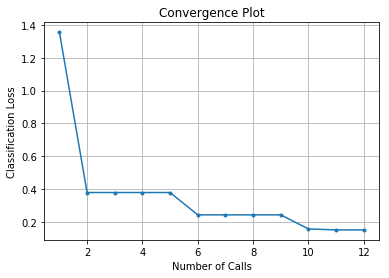

In [16]:
# adapted from skopt.plots.plot_convergence
n_calls = len(res_gp.x_iters)
mins = [np.min(res_gp.func_vals[:i])
        for i in range(1, n_calls + 1)]
plt.plot(range(1, n_calls + 1), np.array(mins), marker='.')
plt.title("Convergence Plot")
plt.ylabel("Classification Loss")
plt.xlabel("Number of Calls")
plt.grid()
plt.savefig(RESULTS_PATH + "convergence_plot.pdf", format='pdf')

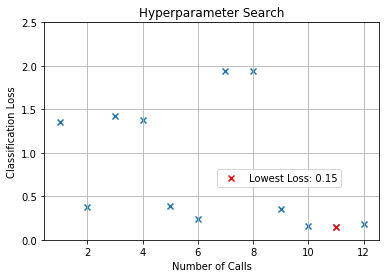

In [13]:
plt.scatter(range(1, n_calls + 1), (np.array(res_gp.func_vals)), marker='x')
plt.scatter([np.argmin(res_gp.func_vals)+1],[res_gp.fun],
            marker='x', color='red',
            label="Lowest Loss: " + str(round(res_gp.fun, 2)))
plt.legend(bbox_to_anchor=(0.5,0.35), loc="upper left")
plt.ylabel("Classification Loss")
plt.xlabel("Number of Calls")
plt.ylim(0,2.5)
plt.grid()
plt.title("Hyperparameter Search")
plt.savefig(RESULTS_PATH + "hyperparameter_search.pdf", format='pdf')

Parameters Tried:
TODO: add rceptive field calculation

In [12]:
for count, parameters in enumerate(res_gp.x_iters):
    print("Search:", count+1)
    for index, parameter in enumerate(parameters):
        print(dimensions[index] + ":", parameter)
    print(" ")

Search: 1
n_filters: 89
kernel_size: 5
dilation_depth: 8
number_of_stacks: 4
pool_size: 8
kernel_size_2: 4
early_stopping_patience: 0
 
Search: 2
n_filters: 37
kernel_size: 3
dilation_depth: 5
number_of_stacks: 3
pool_size: 7
kernel_size_2: 4
early_stopping_patience: 3
 
Search: 3
n_filters: 64
kernel_size: 4
dilation_depth: 5
number_of_stacks: 4
pool_size: 5
kernel_size_2: 7
early_stopping_patience: 1
 
Search: 4
n_filters: 109
kernel_size: 4
dilation_depth: 7
number_of_stacks: 3
pool_size: 7
kernel_size_2: 5
early_stopping_patience: 3
 
Search: 5
n_filters: 42
kernel_size: 3
dilation_depth: 3
number_of_stacks: 3
pool_size: 5
kernel_size_2: 3
early_stopping_patience: 1
 
Search: 6
n_filters: 32
kernel_size: 3
dilation_depth: 9
number_of_stacks: 3
pool_size: 10
kernel_size_2: 7
early_stopping_patience: 4
 
Search: 7
n_filters: 110
kernel_size: 2
dilation_depth: 7
number_of_stacks: 3
pool_size: 4
kernel_size_2: 4
early_stopping_patience: 3
 
Search: 8
n_filters: 128
kernel_size: 3
dilat

# Comparison with parameters before search

In [22]:
bin_range = (0, 63)
data_shape = (3000, 32)

activation = 'softmax'

epochs = 10  # number of epochs limited to 10 to allow more searches (15 hours per evaluation = 11 searches in one week)
batch_size = 16

num_dense_nodes = 512

residual_l2 = 0.001
conv_l2 = 0.001
fully_l2 = 0.001
use_batch_norm = False

# Parameters for data generators
data_gen_params = {'dim': data_shape,
                   'batch_size': batch_size,
                   'n_classes': nb_classes,
                   'data_directory': DATA_PATH_NO_MTI,
                   'bin_range': bin_range,
                   'every_second_cell': True}

In [23]:
params = {
    "n_filters": 64,
    "kernel_size": 2,
    "dilation_depth": 8,
    "number_of_stacks": 3,
    "pool_size": 4,
    "kernel_size_2": 8,
    "early_stopping_patience": -1
}

In [24]:
params = [64, 2, 8, 3, 4, 8, -1]

In [22]:
loss = objective(params)

Epoch 1/10


ResourceExhaustedError: OOM when allocating tensor with shape[16,64,1,3000] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[Node: training/Adam/gradients/conv1d_48/convolution/Conv2D_grad/Conv2DBackpropInput = Conv2DBackpropInput[T=DT_FLOAT, data_format="NCHW", dilations=[1, 1, 1, 1], padding="SAME", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/device:GPU:0"](training/Adam/gradients/conv1d_48/convolution/Conv2D_grad/Conv2DBackpropInput-0-VecPermuteNHWCToNCHW-LayoutOptimizer, conv1d_48/convolution/ExpandDims_1, training/Adam/gradients/conv1d_48/convolution/Conv2D_grad/Conv2DBackpropFilter-2-TransposeNHWCToNCHW-LayoutOptimizer)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


In [23]:
print(loss)

NameError: name 'loss' is not defined

In [ ]:
with open(RESULTS_PATH + "base_evaluation.pkl", 'wb') as file:
    pickle.dump(loss, file)

In [25]:
with open(RESULTS_PATH + "base_evaluation.pkl", 'rb') as file:
    loss = pickle.load(file)

In [26]:
print("Base Loss:", loss)

Base Loss: 0.7047507423046598
